In [1]:
import os
import pandas as pd
import joblib
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

In [2]:

# Load preprocessed data splits from .pkl files
def load_splits(save_dir):
    """
    Loads the data splits from .pkl files.

    Parameters:
        save_dir (str): Directory containing the .pkl files.

    Returns:
        dict: Dictionary containing the loaded data splits.
    """
    data_splits = {}
    for file_name in os.listdir(save_dir):
        if file_name.endswith(".pkl"):
            key = file_name.split(".pkl")[0]
            file_path = os.path.join(save_dir, file_name)
            with open(file_path, "rb") as f:
                data_splits[key] = pickle.load(f)
    print(f"Data splits loaded from .pkl files in directory: {save_dir}")
    return data_splits

In [3]:

# Directory for the preprocessed data
processed_data_dir = "../dataset/splits_pkl"



In [4]:
# Load data splits
data_splits = load_splits(processed_data_dir)

Data splits loaded from .pkl files in directory: ../dataset/splits_pkl


In [5]:
# Access loaded data splits
X = data_splits["X"]
y = data_splits["Y"]
X_train = data_splits["X_train"]
X_val = data_splits["X_val"]
X_test = data_splits["X_test"]
y_train = data_splits["y_train"]
y_val = data_splits["y_val"]
y_test = data_splits["y_test"]


In [6]:
# Logistic Regression Model
model_lr = LogisticRegression(max_iter=10000,solver='lbfgs' ,random_state=42)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)


In [7]:
# Random Forest Model
model_rf = RandomForestClassifier(random_state=42,n_estimators=200,max_depth=10,n_jobs=-1)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

In [8]:
# Evaluation Metrics
def evaluate_model(y_test, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)




In [9]:
# Evaluate Logistic Regression Model
evaluate_model(y_test, y_pred_lr, "Logistic Regression")




Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85295
           1       0.97      0.92      0.95     85294

    accuracy                           0.95    170589
   macro avg       0.95      0.95      0.95    170589
weighted avg       0.95      0.95      0.95    170589

Confusion Matrix:
[[83171  2124]
 [ 6746 78548]]


In [10]:
# Evaluate Random Forest Model
evaluate_model(y_test, y_pred_rf, "Random Forest")


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     85295
           1       1.00      0.98      0.99     85294

    accuracy                           0.99    170589
   macro avg       0.99      0.99      0.99    170589
weighted avg       0.99      0.99      0.99    170589

Confusion Matrix:
[[85153   142]
 [ 1882 83412]]


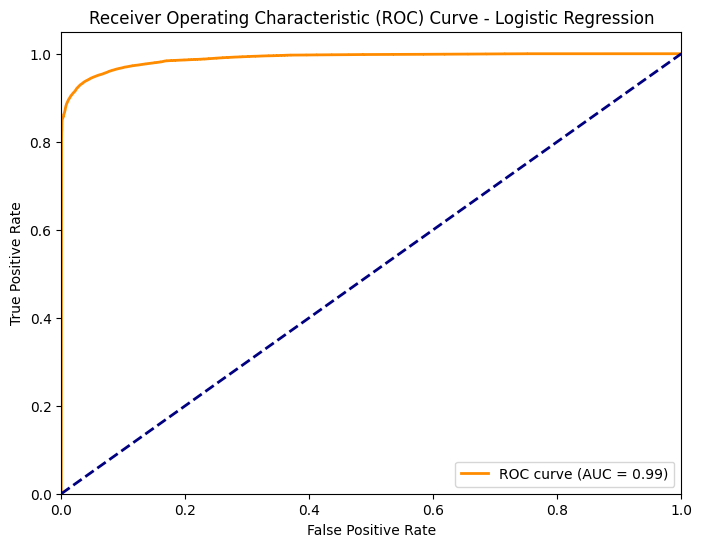

In [11]:
# ROC Curve for Logistic Regression
# Calculate ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, model_lr.predict_proba(X_test)[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()



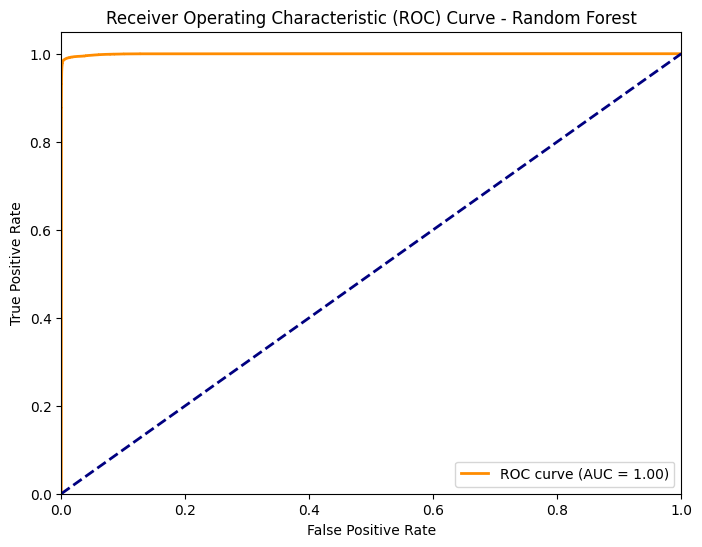

In [12]:
# ROC Curve for Random Forest
# Calculate ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, model_rf.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()


In [13]:
# Define evaluation metrics
def evaluate_with_cross_validation(model, X, y, model_name, cv=5):
    """
    Evaluate a model using k-fold cross-validation.

    Parameters:
        model: The machine learning model to evaluate.
        X: Features.
        y: Target variable.
        model_name: Name of the model (for display).
        cv: Number of cross-validation folds.

    Returns:
        Mean ROC-AUC score across all folds.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    auc_scores = cross_val_score(
        model, X, y, cv=skf, scoring=make_scorer(roc_auc_score, needs_proba=True)
    )
    print(f"{model_name} Mean ROC-AUC (Cross-Validation): {auc_scores.mean():.4f}")
    print(f"{model_name} ROC-AUC Scores per Fold: {auc_scores}")
    return auc_scores

In [14]:
# Cross-Validation for Logistic Regression
model_lr = LogisticRegression(max_iter=10000, random_state=42,solver='lbfgs')
auc_lr = evaluate_with_cross_validation(model_lr, X, y, "Logistic Regression")

d:\Anaconda\envs\gpu_env\lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Logistic Regression Mean ROC-AUC (Cross-Validation): 0.9893
Logistic Regression ROC-AUC Scores per Fold: [0.98979319 0.9892523  0.98931061 0.98932287 0.98901124]


In [15]:
# Cross-Validation for Random Forest
model_rf = RandomForestClassifier(random_state=42,n_estimators=200,max_depth=10,n_jobs=-1)
auc_rf = evaluate_with_cross_validation(model_rf, X, y, "Random Forest")

d:\Anaconda\envs\gpu_env\lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Random Forest Mean ROC-AUC (Cross-Validation): 0.9995
Random Forest ROC-AUC Scores per Fold: [0.99956518 0.99951179 0.9995569  0.99951869 0.99947542]


In [16]:
# Create Models directory if it doesn't exist
models_dir = '../Models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [17]:
# Save the Logistic Regression Model
lr_model_path = os.path.join(models_dir, 'fraud_detection_logistic_regression_model.pkl')
joblib.dump(model_lr, lr_model_path)

['../Models\\fraud_detection_logistic_regression_model.pkl']

In [18]:
# Save the Random Forest Model
rf_model_path = os.path.join(models_dir, 'fraud_detection_random_forest_model.pkl')
joblib.dump(model_rf, rf_model_path)



['../Models\\fraud_detection_random_forest_model.pkl']